 # Optimización multiobjetivo (MOO) para un sistema Microgrid con fuentes renovables

## Contextualización y definición del problema
El objetivo principal trata en optimizar la gestión de energía en una microrred renovable, simulada sobre datos reales del año 2021. Este sistema contiene un consumidor y dos productores de energía (eólica y solar) que abastecen la demanda del primero. La generación de energía o potencia horaria se emula mediante la inferencia de dos modelos lineales preentrenados y a partir de las mediciones de `data/data_complete_w_pred.csv`. El sistema procurará balancear la ganancia de los productores mediante la energía, a la vez que busca la oferta más económica para consumidor dentro de unas consideraciones físicas y técnicas. Para ello, se han hecho las siguientes consideraciones:

- El horizonte temporal $T$ constará de 24 horas de operación.
- Cada productor tiene como finalidad __maximizar su beneficio propio__.
- El consumidor aspira a __minimizar su gasto__.
- El sistema debe cubrir al menos el __95% de la demanda__ diaria.

Dadas las premisas generales impuestas, estamos ante un problema de __optimización multiobjetivo con restricciones__, para el cual aplicaremos diversos algoritmos evolutivos y analizaremos los resultados de estos mismos. 

## Definición formal del problema
### Datos y parámetros especiales
Se describen, previo a la definición completa del problema, los datos y variables que se van a emplear. Los datos horarios se encuentran definidos en `data/data_complete_w_pred.csv` (en celdas próximas se da la conversión a kWh):
- __Horizonte temporal__: $T$ ($t$ representa un paso o una hora).
- __Datos horarios__ ($t$):
  1. $D_{t}$: demanda a abastecer del consumidor, representado en kWh (`demanda_W`). 
  2. $Pred_{S,t}, Pred_{W,t}$: predicciones de generación solar y eólica, respectivamente (kWh). Obtenidos a partir de modelos ML preentranados y ilustrados en los datos como `power_sol_W` y `power_eol_W` (conversión más adelante).
  3. $p_{t}$: precio ofertado por parte de los productores al cliente/consumidor en €/kWh (`p_t` definido más adelante).
- Constantes:
  1. $\eta$ = 0.95: eficiencia de las fuentes renovables o margen de seguridad sobre las predicciones.
  2. $p^{exc}$ = 0.10 €/kWh: precio fijo de venta del excedente a la red general (valor aproximado de 2021).
  3. $c_{s} = 0.05$, $c_{w} = 0.03$: coste nivelado de la energía (LCOE) asignados a la generación solar y eólica en 2021, respectivamente (€/kWh) [1][2].
  
__Fuentes__:

[1] IRENA, "Global solar LCOE fell 3% between 2021 and 2022," PV Tech, 2022. [Online]. Disponible en: https://www.pv-tech.org/irena-global-solar-lcoe-fell-3-between-2021-and-2022/

[2] Fraunhofer ISE, "Levelized Cost of Electricity: PV and storage," 2021. [Online]. Disponible en: https://www.energie.fraunhofer.de/en/press-media/press-release/press-realeases-2021/PI-210622-fraunhofer-ise-levelized-cost-of-electricity.html  

### Representación del individuo
Suponiendo un horizonte temporal $T = 24$, para cada hora $t \in \{1, \dots, T\}$ se definen los siguientes genes o alleles: 
- $( e_{S,t} \in \mathbb{R}_{\geq 0} )$: energía generada por el productor solar (kWh).
- $( e_{W,t} \in \mathbb{R}_{\geq 0} )$: energía generada por el productor eólico (kWh).

Por lo que, la representación de un individuo (genotipo) se define como:

$$
\mathbf{x} = [e_{S,1}, \dots, e_{S,T}, e_{W,1}, \dots, e_{W,T}] \in \mathbb{R}^{2T}
$$
En la cual, por cada hora tenemos la energía producida correspondiente a ambas fuentes renovables; en total $2T$ genes por individuo. El orden de primero tener los 24 valores
de energía de la solar y depués las de la planta eólica tiene un propósito principal
directo: el poder calcular el precio o la función objetivo directamente para cada fuente de
generación. De está manera podemos calcular la ganancia de cada generador sin conflictos y de manera sencilla (además de aplicar operadores). Cabe destacar que en todo momento se respetarán los límites establecidos para cada hora por el modelo de ML (nuestra variable Pred_x_t); e.g. aunque se realice un crossover y a las 3 a.m. se establezca una producción solar de 50 kWh (exageración), esto no se aceptará y se establecera una potencía dentro del rango real.

### Funciones objetivo
Siendo el excedente total de un día dado,
$$
\text{exc}_t=\max\!\bigl(0,\;e_{S,t}+e_{W,t}-D_t\bigr),\qquad   
\text{Exc}   =\sum_{t=1}^{T}\text{exc}_t
$$

definimos la fracción de energía sobregenerada para cada productor:

$$
\text{frac}_S=\frac{\displaystyle\sum_{t=1}^{T} e_{S,t}}
                    {\displaystyle\sum_{t=1}^{T} \bigl(e_{S,t}+e_{W,t}\bigr)}
              \quad\bigl(0\le \text{frac}_S\le 1\bigr),
$$

Es decir, tanto el productor solar como eólico (W) son asignados la fracción de excedente que le corresponde a cada uno. Esto supondrá un ingreso extra para cada uno.

Por lo cual, se busca optimizar simultáneamente tres funciones objetivo:

1. __Maximizar la ganancia del productor solar__:  
$$
f_{1}(\mathbf x)=-
  \Bigl[
     \sum_{t=1}^{T} (p_t-c_{s})\,e_{S,t}\;
     +\;p^{\text{exc}}\;\text{frac}_S\;\text{Exc}
  \Bigr]
$$

2. __Maximizar la ganancia del productor eólico__:  
$$
f_{2}(\mathbf x)=-
  \Bigl[
     \sum_{t=1}^{T} (p_t-c_{w})\,e_{W,t}\;
     +\;p^{\text{exc}}\;\bigl(1-\text{frac}_S\bigr)\;\text{Exc}
  \Bigr]
$$

3. __Minimizar el gasto del consumidor__:  
$$
f_{3}(\mathbf x)=
  \sum_{t=1}^{T} p_t\;\min\!\bigl(D_t,\;e_{S,t}+e_{W,t}\bigr)
$$

> __Nota__: los valores se expresan con signo negativo las funciones a "maximizar" para cumplir con el estándar de los algoritmos evolutivos: minimizar la función objetivo.

### Restricciones consideradas

El sistema deberá de cumplir con los siguientes $\textit{constraints}$:

- __Cobertura mínima__: en cada hora $t \in \{1, \dots, T\}$ se debe abastecer al menos el 95 % de la demanda del cliente:  
$$
g(\mathbf x)=
  0.95\sum_{t=1}^{T} D_t
  \;-\;
  \sum_{t=1}^{T}\bigl(e_{S,t}+e_{W,t}\bigr)
  \;\;\le 0
$$

- __Límites de generación__ (generación negativa y por encima de lo logrado en la inferencia):
$$
\begin{aligned}
0 &\leq e_{S,t} \leq \eta \cdot G_{S,t} \\
0 &\leq e_{W,t} \leq \eta \cdot G_{W,t}
\end{aligned}
$$
> __Nota__: en la definición del problema no es una restricción per se, pero se límita mediante `xl`y `xu`.

## Configuración inicial y operadores seleccionados
A partir de la definición formal del problema, se ha decidido inicializar una población de 91 individuos (por las referencia de direcciones (rayos) default de pymoo para NSGA-III) para 200 generaciones. De esta manera podremos comprobar que plan de gestión diario (individuos) logra un mejor rendimiento y gestión del sistema para todos los actores del microgrid. 

Dada la representación continua que hemos seleccionado, en caso de necesitarlo, podríamos definir los siguientes operadores con facilidad para redondear nuestro esquema general de MOO:
  - Crossover: SBX con probabilidad 0.9 (aleatorio, para iniciar).
  - Mutación: Polynomial, con probabilidad $(1 / n_{var})$.

En este caso vamos a utilizar algoritmos SotA que ya tienen todo el esquema con operadores predefinidos.

## Justificación del uso de `Pymoo`

Se ha elegido la librería `Pymoo` frente a `jMetalPy` por las siguientes razones:

- __Mayor documentación__ en caso de dudas o errores.
- Tiene integrado los algoritmos NSGA-II, NSGA-III y SPEA2 integramente.
- __Visualización completa__ (2D, 3D y frente de Pareto).
- Optimizado con `Cython` para un rendimiento competitivo.

En la siguiente sección se cargan los datos y se prepara la estructura del problema.

__Una vez definido el problema en su totalidad, realizaremos la optimización con tres algoritmos distintos: NSGA-II, NSGA-III y SPEA2. Además de sacar conclusiones fundadas en los resultados individuales de cada algortimo, trataremos también de identificar diferencias entre las herramientas en cuanto a rendimiento y solución se refiere.

In [1]:
# Librerías necesarias a cargar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D 

# Pymoo: modulos para definir el problema y los algoritmos a utilizar.
from pymoo.core.problem import Problem # Constructor para heredar en la definición del MOO.
from pymoo.operators.sampling.rnd import FloatRandomSampling # Para iniciar la población de manera aleatoria dentro de los límites.
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions # Genera las direcciones de referencia o los rayos.

# Métricas de calidad y visualización
from pymoo.indicators.hv import HV
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from pymoo.indicators.spacing import SpacingIndicator

# Clustering para seleccionar los días más representativos del año 2021.
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Callback para poder ver la evolución por generación y animación.
from pymoo.core.callback import Callback
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Para evitar warnings en consola
import warnings; warnings.filterwarnings("ignore")

## 1. Carga de datos y procesamiento
Simplemente pasamos la producción/demanda y el precio a la unidad estándar que hemos definido previamente (kWh y €/kWh, respectivamente).

In [2]:
# Cargamos el archivo que contiene los datos de mediciones, demanda, precio...
df = pd.read_csv("data/data_complete_w_pred.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           8760 non-null   int64  
 1   Date                 8760 non-null   object 
 2   temperature_2m       8760 non-null   float64
 3   relativehumidity_2m  8760 non-null   int64  
 4   dewpoint_2m          8760 non-null   float64
 5   windspeed_10m        8760 non-null   float64
 6   windspeed_100m       8760 non-null   float64
 7   winddirection_10m    8760 non-null   int64  
 8   winddirection_100m   8760 non-null   int64  
 9   windgusts_10m        8760 non-null   float64
 10  WindSpeed            8760 non-null   float64
 11  Sunshine             8760 non-null   float64
 12  AirPressure_FV       8760 non-null   float64
 13  Radiation            8760 non-null   float64
 14  RelativeAirHumidity  8760 non-null   int64  
 15  precio_eur_Wh        8760 non-null   f

In [3]:
# Creamos una copia que utilizaremos en todo el proceso (para no sobreescribir en original).
df_copy = df

# Realizamos la conversión de unidades.
df_copy["demanda_kWh"] = df_copy["demanda_W"] / 1000
df_copy["Pred_S_t"] = df_copy["power_sol_W"] / 1000  # Predicción solar.
df_copy["Pred_W_t"] = df_copy["power_eol_W"] / 1000  # Predicción wind.
df_copy["p_t"] = df_copy["precio_eur_Wh"] * 1000  # Precio en €/kWh.

# Seleccionamos un día aleatorio.
window = df_copy.iloc[:24].copy()

# Preparamos arrays con los nombres de las variables y constantes que hemos definido.
D_t = window["demanda_kWh"].values
Pred_S_t = np.maximum(window["Pred_S_t"].values, 0) # Por si acaso aunque previamente en `data_adaptation.py` se ha hecho un clipping.
Pred_W_t = np.maximum(window["Pred_W_t"].values, 0)
p_t = window["p_t"].values

# Verificación rápida con las 3 primeras horas.
print("Demanda primeras 3h:", D_t[:3])
print("Generación solar:", Pred_S_t[:3])
print("Generación eólica:", Pred_W_t[:3])
print("Precio energía:", p_t[:3])

Demanda primeras 3h: [0.84981605 1.08028572 0.99279758]
Generación solar: [0. 0. 0.]
Generación eólica: [0.02159567 0.01625594 0.02015442]
Precio energía: [0.000703 0.000703 0.000703]


## 2. Definición del problema con `pymoo`
Creamos una clase donde definimos todas las variables/constantes, representación de los individuos (genotipos), definimos funciones objetivo, restricciones... el problema MOO integro.

In [4]:
# Precio de venta del excedente a la red (para cada productor).
P_SELL = 0.1 # €/kWh

class MicrogridMOODef(Problem):
    """
    Clase base que define el problema de optimización multiobjetivo completo con
    dos productores (solar y eólico) y un consumidor. Hereda el constructor
    `pymoo.core.Problem` para crear el Problem.

    Las funciones objetivos son:
    1. + 2. Maximizar el beneficio del productor solar y eólico.
    3. Minimizar el gasto del consumidor.

    Dos restricciones consideradas:
    - Cobertura mínima del 50 % de la demanda diaría.
    """

    def __init__(self, D_t, Pred_S_t, Pred_W_t, p_t, eta=0.95, c_s=0.05, c_w=0.03):
        """
        Parámetros/constantes de entrada:
        - D_t: array de demanda horaria (kWh).
        - Pred_S_t: predicción solar horaria (kWh).
        - Pred_W_t: predicción eólica horaria (kWh).
        - p_t: precio horario de la energía (€/kWh).
        - eta: margen de seguridad aplicado a la generación.
        - c_s: coste nivelado solar (€/kWh).
        - c_w: coste nivelado eólico (€/kWh).
        """
        self.T = len(D_t)
        self.D_t = D_t
        self.Pred_S_t = Pred_S_t
        self.Pred_W_t = Pred_W_t
        self.p_t = p_t
        self.eta = eta
        self.c_s = c_s
        self.c_w = c_w

        n_var=2*self.T

        # Por si los datos no estuviesen limpios y hubiese algún valor negativo.
        self.xl = np.zeros(n_var)
        self.xu = np.concatenate([
            np.maximum(0, eta * Pred_S_t),
            np.maximum(0, eta * Pred_W_t)
        ])
        # Llamada al constructor de Problem (pymoo) para generar nuestro MOO.
        super().__init__(
            n_var=n_var, # Genes: energía solar y eólica horaria.
            n_obj=3, # Tres funciones objetivo en total.
            n_constr=1,
            # n_constr=self.T, # Una restricción por hora (cobertura mínima).
            xl=np.zeros(2*self.T), # Límite inferior (0). No se puede generar energía negativa.
            xu=np.concatenate([eta * Pred_S_t, eta * Pred_W_t]) # Límite superior según la predicción 
            # (Nunca se asignara a pesar de crossover una producción que no corresponda a los límites de una hora e.g. a las 4 am no habrá una producción solar mayor a 0 kWh, si el modelo ML así lo ha inferido).
        )

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Calcula las funciones objetivo y restricciones para una población de
        soluciones x. En nuestro caso, hemos definido 40 individuos.
        """
        T = self.T
        p_t = self.p_t
        D_t = self.D_t
        c_s = self.c_s
        c_w = self.c_w

        # Separamos los genes correspondientes a solar y eólico para poder calcular las funciones objetivo.
        e_s = x[:, :T] # Energía solar producida por hora.
        e_w = x[:, T:] # Energía eólica entregada por hora.

        # Calculamos los ingresos directos (simple) para cada productor por la energía generada.
        ing_s = np.sum(p_t * e_s, axis=1)
        ing_w = np.sum(p_t * e_w, axis=1)

        # Calculamos el excedente de cada productor y calculamos el dinero respecto al precio de venta.
        excedente = np.maximum(0.0, (e_s + e_w) - self.D_t)
        exc_tot = np.sum(excedente, axis=1) 
        gen_tot = np.sum(e_s + e_w, axis=1).astype(float) 

        # Para asignar el excedente que corresponde a cada productor.
        frac_s = np.divide(np.sum(e_s, axis=1), gen_tot,
                                 out=np.zeros_like(gen_tot),
                                 where=gen_tot>0)                   # proporción solar

        ing_exc_s = P_SELL * exc_tot * frac_s
        ing_exc_w = P_SELL * exc_tot * (1 - frac_s)

        # Por último, antes de definir las funciones objetivo, calculamos el coste de producción por energía.
        cost_s = np.sum(self.c_s * e_s, axis=1)
        cost_w = np.sum(self.c_w * e_w, axis=1)

        f1 = -(ing_s + ing_exc_s - cost_s) # Ganancia de la planta solar (disclaimer! max → min -f).
        f2 = -(ing_w + ing_exc_w - cost_w) # Ganancia del productor eólico.

        # El consumidor solo pagará por lo que haya consumido (no también el excedente)!!
        cons = np.minimum(self.D_t, e_s + e_w)
        f3 = np.sum(p_t * cons, axis=1) # Gasto total del consumidor.

        out["F"] = np.column_stack([f1, f2, f3]) # Matriz de objetivos.

        # Restricciones (una por día o individuo): abastecer el 95 % de la demanda del día dado.
        cov_gap = 0.95 * self.D_t.sum() - np.sum(e_s + e_w, axis=1) # Si el valor es negativo, la demanda está cubierta.
        out["G"] = cov_gap[:, None]     

También vamos a crear un Callback para poder registrar cada iteración de los algoritmos y poder monitorizar que está ocurriendo por cada iteración.

## 3. Generamos una población inicial para comprobar y visualizar

In [5]:
# Tamaño de población inicial.
pop_size = 5  

# Generamos mediante un sampling aleatorio dentro de nuestros límites de generación.
sampling = FloatRandomSampling()
X_init = sampling.do(problem=MicrogridMOODef(D_t, Pred_S_t, Pred_W_t, p_t), n_samples=pop_size).get("X")

# Visualizamos el primer individuo para comprobar que todo se ha generado de manera correcta.
individuo = X_init[0]
T = len(D_t)
e_s = individuo[:T]
e_w = individuo[T:]

# Mostramos la información de nuestro primer individuo.
df_init = pd.DataFrame({
    "Hora": range(T),
    "Energía solar producida (kWh)": e_s,
    "Energía eólica producida (kWh)": e_w,
    "Demanda (kWh)": D_t,
    "Cobertura (%)": 100 * (e_s + e_w) / D_t
})
df_init

,Hora,Energía solar producida (kWh),Energía eólica producida (kWh),Demanda (kWh),Cobertura (%)
0,0,0.000000,0.007529,0.849816,0.885972
1,1,0.000000,0.000033,1.080286,0.003093
2,2,0.000000,0.016634,0.992798,1.675433
3,3,0.000000,0.016005,0.939463,1.703604
4,4,0.016991,0.002008,0.762407,2.491941
5,5,0.000429,0.014612,0.131199,11.463842
6,6,0.001913,0.016982,0.111617,16.928565
7,7,0.002597,0.005747,0.273235,3.053781
8,8,0.000000,0.003374,0.220223,1.531976
9,9,0.000000,0.010126,0.241615,4.190847


Podemos ver que se ha generado correctamente nuestro individuo con $2T$ genes con la energía producida para ambas fuentes renovables. La demanda definida ha sido bastnate realista y teniendo en cuenta las reducidas horas pico de los productores, abastecer el 50% de la demanda sera difícil para todo el día. Ahí es donde veremos cual es la mejor gestión o individuo para mantener un sistema con únicamente dos fuentes irregulares durante un día entero.

## 4. Prueba inicial en los escenarios más significativos
Para no realizar un overkill hemos decidido lo siguiente: en vez de realiza la optimización para todo el añó 2021, seleccionaremos únicamente cuatro días representativos de nuestro dataset + 2 extremos (mejor y peor producción diaria). Para lograr esto, generaremos un vector de caraterísticas diario y aplicaremos k-means (k = 4). De esta manera podremos ver como se comportan ante panoramas distintos los tres algoritmos evolutivos con los que vamos a trabajar: NSGA-II, NSGA-III y SPEA2.

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
# Para después poder ver el perfil de los días que seleccionemos.
df_copy["Hour"] = df_copy["Date"].dt.hour

# Convertimos la columna `Date` a sin horas, unicamente el día. 
df_copy["Date"] = df_copy["Date"].dt.date


daily = (df_copy
         .groupby("Date")
         .agg(solar_E   = ("Pred_S_t",   "sum"),
              wind_E    = ("Pred_W_t",   "sum"),
              demand_E  = ("demanda_kWh","sum"),
              var_solar = ("Pred_S_t",   "var"),
              var_wind  = ("Pred_W_t",   "var"))
        )

# Normalizamos las variables para que todos los features pesen lo mismo y evitar sesgos por escala.
X = StandardScaler().fit_transform(daily)

# 3) K-means con k = 4.
k = 4
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42).fit(X)

# Cada uno de los 4 días representativos son aquellos puntos más cercanos a cada centroide de cada cluster.
centers = kmeans.cluster_centers_
dists   = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
means_idx = np.argmin(dists, axis=0)    

# Seleccionamos también los días con peor y mejor producción del año. 
ren_frac = (daily["solar_E"] + daily["wind_E"]) / daily["demand_E"]
dia_min  = ren_frac.idxmin()
dia_max  = ren_frac.idxmax()

# Selección final de los seís días. 
seleccion = set(daily.index[means_idx])
seleccion.update([dia_min, dia_max])
dias_sel = sorted(seleccion)

print("Los seís días elegidos:", dias_sel)

Los seís días elegidos: [datetime.date(2021, 1, 9), datetime.date(2021, 4, 23), datetime.date(2021, 6, 28), datetime.date(2021, 8, 2), datetime.date(2021, 9, 21), datetime.date(2021, 10, 13)]


Los perfiles de producción máxima y la demanda para cada uno se visualiza a continuación.

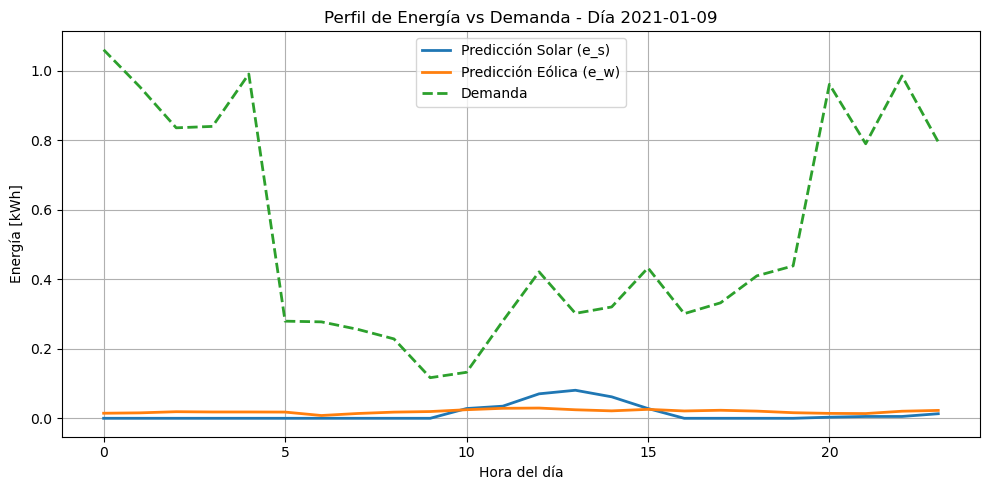

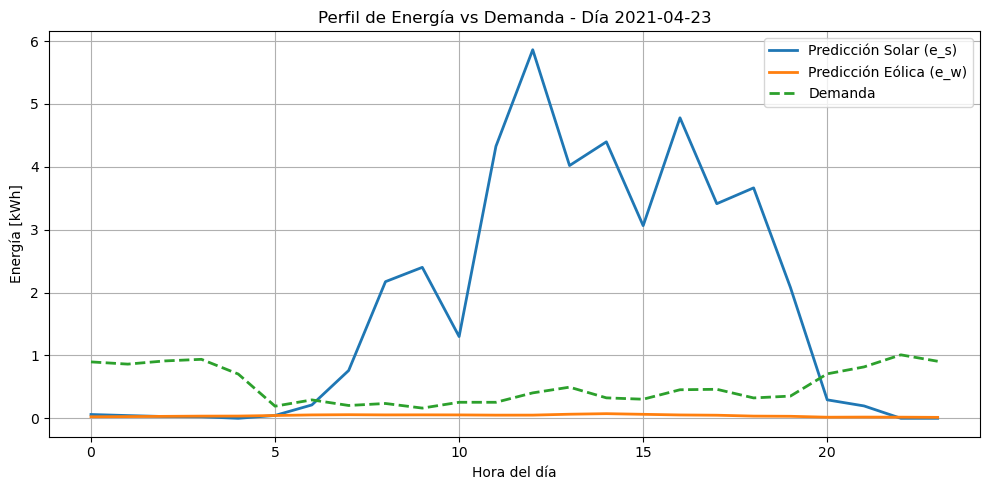

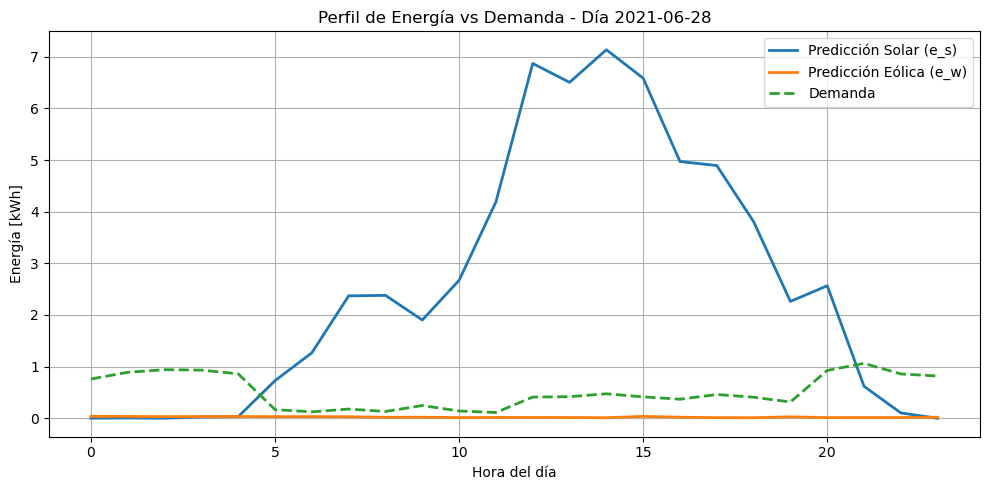

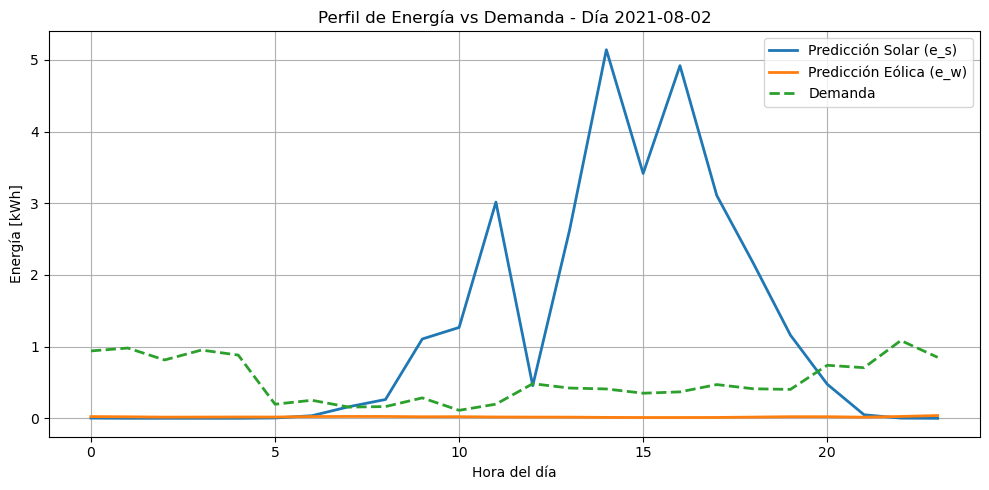

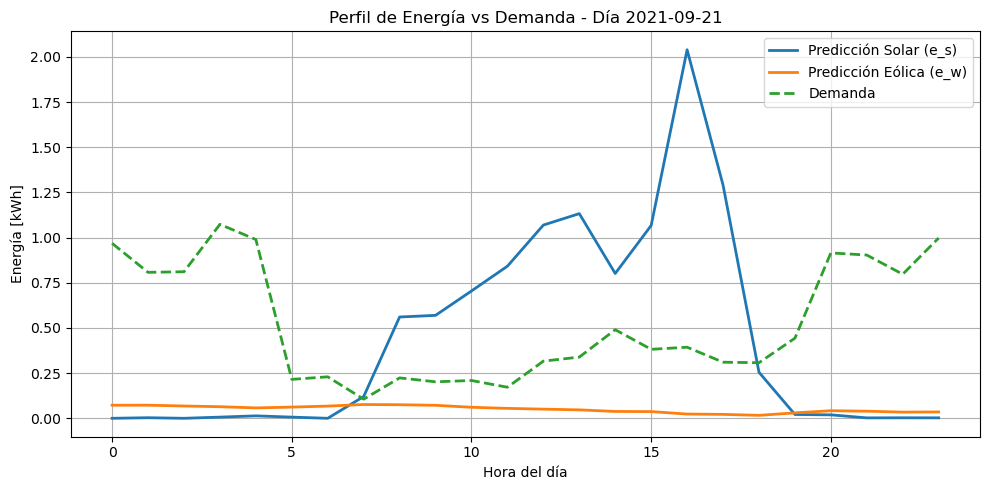

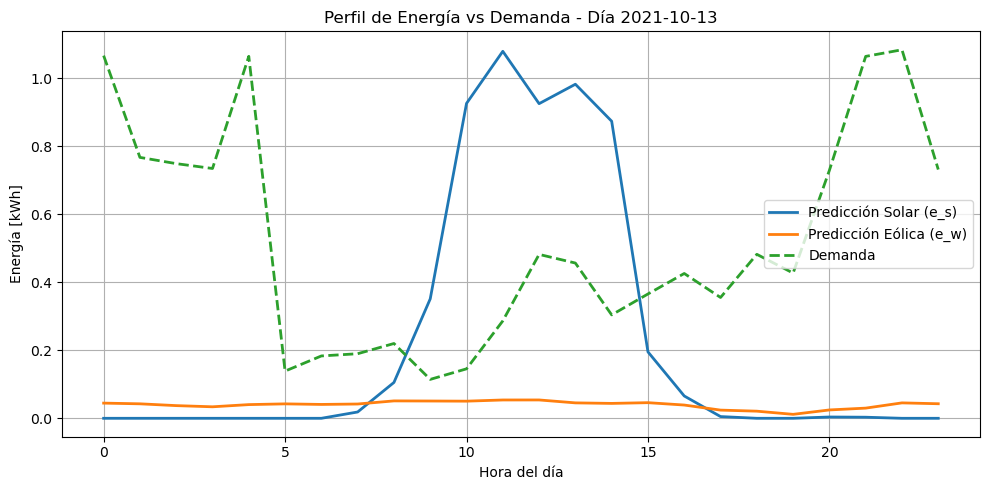

In [7]:
grouped = df_copy[df_copy["Date"].isin(dias_sel)].groupby(["Date", "Hour"]).agg({
    "Pred_S_t": "mean",
    "Pred_W_t": "mean",
    "demanda_kWh": "mean"
}).reset_index()

# ------------------------------
# 5. Plots por día
# ------------------------------
for fecha in dias_sel:
    df_day = grouped[grouped["Date"] == fecha]
    plt.figure(figsize=(10, 5))
    plt.plot(df_day["Hour"], df_day["Pred_S_t"], label="Predicción Solar (e_s)", linewidth=2)
    plt.plot(df_day["Hour"], df_day["Pred_W_t"], label="Predicción Eólica (e_w)", linewidth=2)
    plt.plot(df_day["Hour"], df_day["demanda_kWh"], label="Demanda", linestyle="--", linewidth=2)
    plt.title(f"Perfil de Energía vs Demanda - Día {fecha}")
    plt.xlabel("Hora del día")
    plt.ylabel("Energía [kWh]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Procedemos a ejecutar la optimización con los tres algoritmos que vamos a definir a continuación mediante la clase `ejecutar_alg`. 

In [8]:
def preparar_dia(df, fecha_objetivo):
    """
    Función de ayuda que extrae y prepara los datos para un día dado.
    """
    # Filtramos solo el día deseado (ya es tipo date).
    df_dia = df_copy[df_copy["Date"] == fecha_objetivo].copy()

    # Reconvertimos unidades por si no están listas
    D_t = df_dia["demanda_kWh"].values
    Pred_S_t = df_dia["Pred_S_t"].values
    Pred_W_t = df_dia["Pred_W_t"].values
    p_t = df_dia["p_t"].values

    return D_t, Pred_S_t, Pred_W_t, p_t

Definimos a su vez un método helper que nos ayude a construir un punto de referencia Nadir con respecto a cada día que estamos ejecutando. De esta manera no nos arriesgamos a coger uno con un margen o muy grande o muy pequeño y la evaluación de calidad es más verosimil.

In [9]:
def ref_point(res_dict, margen=0.05):
    """
    Calcula z_ref = z_nad * (1 + margen) a partir de los tres algoritmos (unicamente para gasto consumidor).
    En el caso de los productores se define una ganancia nula como punto de referencia.

    """
    # Misma función que en ejecutar_alg para obtener los frentes necesarios.
    def F_safe(r):
        if r.opt is not None and r.opt.get("F") is not None:
            return r.opt.get("F")
        return r.pop.get("F")  

    # Unimos los frentes de los tres métodos.
    F_union = np.vstack([F_safe(r) for r in res_dict.values()])

    # Nadir = máximo columna a columna (porque minimizamos para todas las funciones objetivo).
    z_nad = F_union.max(axis=0)

    # Asignaremos el ref-point ligeramente peor al punto Nadir.
    z_ref = z_nad * (1 + margen)

    # El punto de referencia para las ganancias de los productores lo fijamos en 0. 
    z_ref[:2] = 0.0          # f1 y f2
    return z_ref

In [10]:
def ejecutar_alg(D_t, Pred_S_t, Pred_W_t, p_t, etiqueta="Día"):
    """
    Ejecuta NSGA-II, NSGA-III y SPEA2 para un día concreto. Además ilustra el
    frente de Pareto para todos los algoritmos y calcula las métricas de calidad:
        - HV: hypervolume
        - GD: Generational Distance.
        - IGD: Inverse Generational Distance.
        - Delta: Spacing Indicator (evalua diversity y spread). Cuanto menor, más uniformemente están distribuidas las soluciones.
    """
    # Pruebas para detectar si no hemos logrado ninguna solución o los tamaños de la solución son distintos entre variables.
    assert all(len(x) > 0 for x in (D_t, Pred_S_t, Pred_W_t, p_t)), \
        "Alguno de los vectores de entrada está vacío"
    assert len({len(D_t), len(Pred_S_t), len(Pred_W_t), len(p_t)}) == 1, \
        f"Tamaños incoherentes: {[len(D_t), len(Pred_S_t), len(Pred_W_t), len(p_t)]}"
    
    # Definición mediante instanciación del problema.
    problem = MicrogridMOODef(D_t, Pred_S_t, Pred_W_t, p_t)

    # Algoritmo NSGA-II.
    nsga2 = NSGA2(pop_size=91)
    res2 = minimize(problem, nsga2, termination=("n_gen", 200), save_history = True, verbose=False)

    # NSGA-III con direcciones de referencia (rayos).
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
    nsga3 = NSGA3(ref_dirs=ref_dirs, pop_size=91)
    res3 = minimize(problem, nsga3, termination=("n_gen", 200), save_history = True, verbose=False)

    # SPEA2.
    spea2 = SPEA2(pop_size=91)
    resS = minimize(problem, spea2, termination=("n_gen", 200), save_history = True, verbose=False)

    def F(res):
        """
        Devuelve una matriz (n_sols, n_obj) con los objetivos.
        Prioridad: res.opt → res.pop → res.F
        """
        if res.opt is not None:
            # Frente NO DOMINADO (para Pareto Front).
            return res.opt.get("F")
        # Población completa
        return res.pop.get("F")

    # Visualización rápida de los frentes de Pareto.
    fig = plt.figure(figsize=(8,6))
    ax  = fig.add_subplot(111, projection="3d")
    for Fmat,lbl in [(F(res2),"NSGA-II"), (F(res3),"NSGA-III"), (F(resS),"SPEA2")]:
            ax.scatter(*Fmat.T, label=lbl, alpha=.7)

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='plain')   

    ax.set_xlabel(r"$-\,$Solar earnings", labelpad=12)
    ax.set_ylabel(r"$-\,$Wind earnings",  labelpad=12)
    ax.set_zlabel("Consumer cost",        labelpad=10)

    ax.set_title(f"Pareto Front – {etiqueta}", pad=20)   
    fig.tight_layout()

    ax.legend(loc="best")
    plt.show() 

    resultados = {"NSGA-II":res2, "NSGA-III":res3, "SPEA2":resS}

    # Calculo de las métrias de calidad principales.
    # Definimos el ref point para cada uno de los días.
    z_ref  = ref_point(resultados)    

    # Cogemos el frente global para poder calcular el GD y IGD.
    F_union = np.vstack([F(r) for r in resultados.values()])

    met = {}
    for alg, res in resultados.items():
        F_alg = F(res)                   

        # Unión de los frentes de los OTROS algoritmos.
        F_ref = np.vstack([
            F(r) for a, r in resultados.items() if a != alg
        ])

        met[alg] = {
            "HV": float(HV(ref_point=z_ref).do(F_alg)),
            "GD": float(GD (F_ref).do(F_alg)),   
            "IGD": float(IGD(F_ref).do(F_alg)),  
            "Delta": float(SpacingIndicator().do(F_alg))
        }

    return {"result": resultados, "metrics": met}

## 5. Resultados de la optimización para los seis días seleccionados y resultados.


Ejecutando día 2021-01-09 …


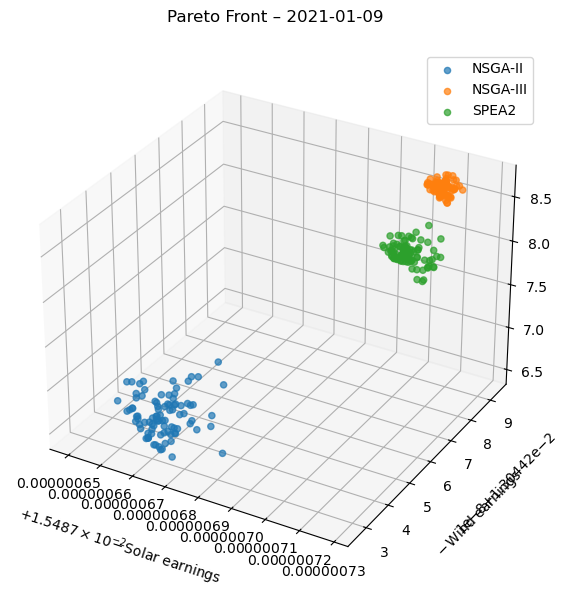


Ejecutando día 2021-04-23 …


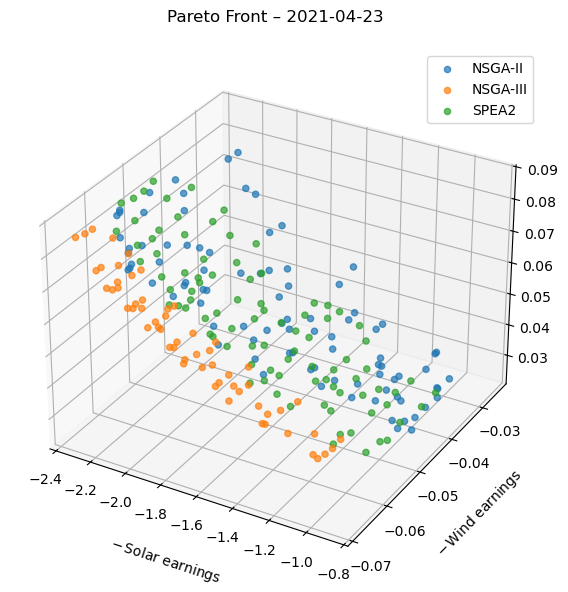


Ejecutando día 2021-06-28 …


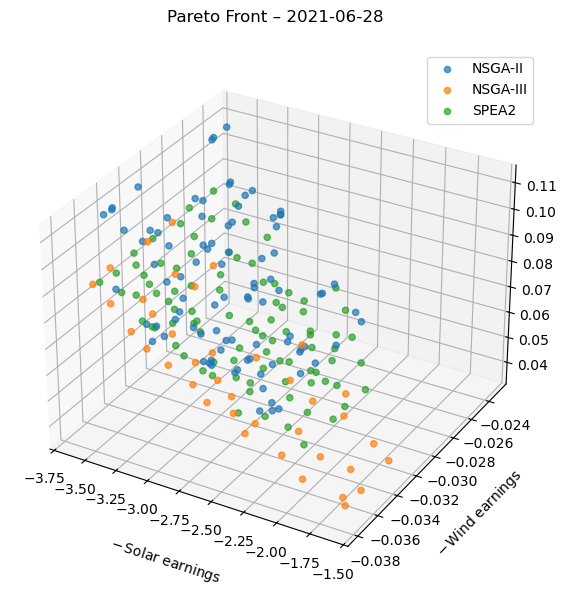


Ejecutando día 2021-08-02 …


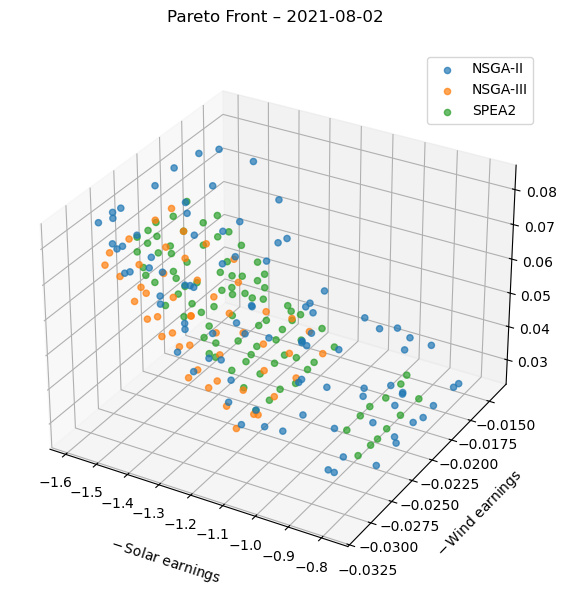


Ejecutando día 2021-09-21 …


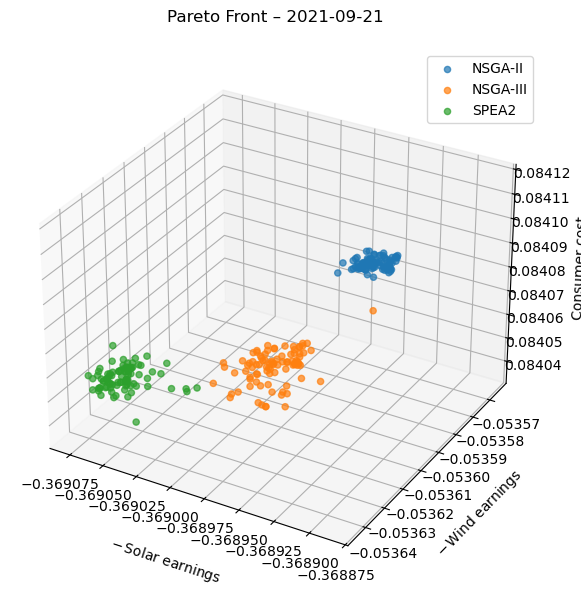


Ejecutando día 2021-10-13 …


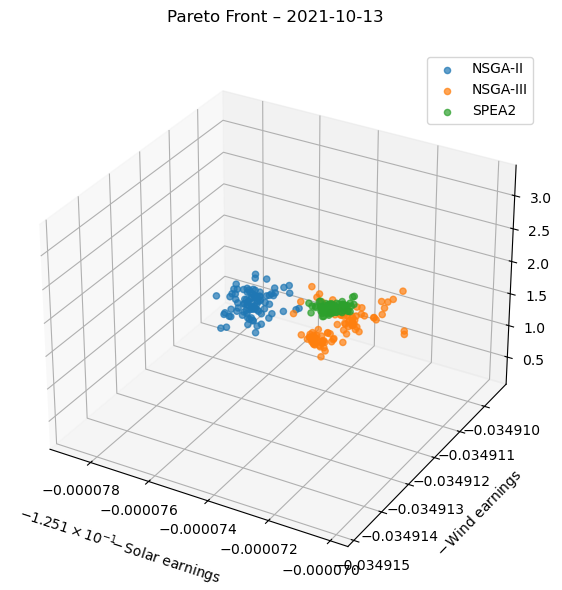


Optimización finalizada.


In [11]:
# Ejecutamos sobre los 6 días seleccionados (4 puntos + 2 extremos).
resultados = {}
for fecha in dias_sel:
    print(f"\nEjecutando día {fecha} …")
    D_t, S_t, W_t, p_t = preparar_dia(df_copy, fecha)
    resultados[str(fecha)] = ejecutar_alg(D_t, S_t, W_t, p_t,
                                                 etiqueta=str(fecha))
print("\nOptimización finalizada.")

Resumen de las métricas de calidad

In [12]:
rows = []
for dia, dic in resultados.items():
    for alg, m in dic["metrics"].items():
        rows.append({"Día": dia, "Algoritmo": alg, **m})

df_metrics = pd.DataFrame(rows)

metricas = ["HV", "GD", "IGD", "Delta"]

resumen = (
    df_metrics
    .groupby("Algoritmo")[metricas] 
    .agg(["mean", "std"])
)

display(resumen)

HV                  GD                 IGD            \
               mean       std      mean       std      mean       std   
Algoritmo                                                               
NSGA-II    0.002695  0.003368  0.007238  0.007989  0.012656  0.021029   
NSGA-III   0.002967  0.003884  0.014945  0.028713  0.018106  0.022175   
SPEA2      0.002787  0.003591  0.004464  0.005273  0.010315  0.013439   

              Delta            
               mean       std  
Algoritmo                      
NSGA-II    0.004522  0.005160  
NSGA-III   0.007329  0.010477  
SPEA2      0.003474  0.004155

In [13]:
def traer_res(resultados, dia, alg):
    """
    Devuelve el objeto pymoo.Result correspondiente a:
        - dia : string  ("2021-04-15", etc.) tal cual aparece en resultados
        - alg : "NSGA-II", "NSGA-III" o "SPEA2"
    """
    return resultados[str(dia)]["result"][alg]

# Gráfica del hipervolumen en el espacio objetivo.
def graficar_hv(res, ref_point, titulo="HV convergence"):
    hv = HV(ref_point)
    gens, valores = [], []

    for h in res.history:                       # h es el algoritmo en esa gen.
        gen = getattr(h, "n_gen", len(gens))    # nº de generación
        # Frente no dominado si existe; si no, toda la población
        F = h.opt.get("F") if (hasattr(h, "opt") and h.opt is not None
                               and len(h.opt) > 0) else h.pop.get("F")
        gens.append(gen)
        valores.append(hv.do(F))

    plt.figure(figsize=(6,4))
    plt.plot(gens, valores, marker="o")
    plt.xlabel("Generation"); plt.ylabel("Hypervolume")
    plt.title(titulo); plt.grid(True); plt.show()

# Evolución y seguimiento de las soluciones respecto a la restricción.
def graficar_cv(res, titulo="Restriction compliance evolution"):
    gens, cv_max, cv_med = [], [], []

    for h in res.history:
        gen = getattr(h, "n_gen", len(gens))
        CV  = h.pop.get("CV")                  # (n_pop, )
        gens.append(gen)
        cv_max.append(CV.max())
        cv_med.append(np.median(CV))

    plt.figure(figsize=(6,4))
    plt.plot(gens, cv_max, label="max")
    plt.plot(gens, cv_med, label="median")
    plt.xlabel("Generation n"); plt.ylabel("CV  (≤0 ⇒ feasible)")
    plt.title(titulo); plt.legend(); plt.grid(True); plt.show()

# Graficamos el mejor individuo vs el individuo inicial (sus genotipos), como un plot en el que visualizamos la generación por fuente de energía y la demanda del consumidor.
def ini_vs_final(ind_a, ind_b, D_t, lbl_a="Inicial", lbl_b="Mejor"):
    T = len(D_t)
    es_a, ew_a = ind_a[:T], ind_a[T:]
    es_b, ew_b = ind_b[:T], ind_b[T:]
    hrs = np.arange(T)

    fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    for j,(es,ew,lbl) in enumerate([(es_a,ew_a,lbl_a),(es_b,ew_b,lbl_b)]):
        ax[j].stackplot(hrs, es, ew, labels=["Solar","Wind"], alpha=.7)
        ax[j].plot(hrs, D_t, "k--", lw=2, label="Demand")
        ax[j].set_title(lbl); ax[j].set_xlabel("Hour")
        ax[j].grid(True); ax[j].legend(fontsize="small")
    ax[0].set_ylabel("Energy (kWh)")
    plt.tight_layout(); plt.show()

Recuperamos la manera de definir el Pareto front que exista y añadimos otro helper puesto que el Pareto Front optimo no es conocido.

In [14]:
def F(res):
    """
    Devuelve una matriz (n_sols, n_obj) con los objetivos.
    Prioridad: res.opt → res.pop → res.F
    """
    if res.opt is not None:
        # Frente NO DOMINADO (para Pareto Front).
        return res.opt.get("F")
    # Población completa
    return res.pop.get("F")

def X_seguro(res):
    """Devuelve la matriz X del frente no dominado si existe;
       de lo contrario, la X de la población final."""
    return res.opt.get("X") if (res.opt is not None and len(res.opt) > 0) else res.pop.get("X")

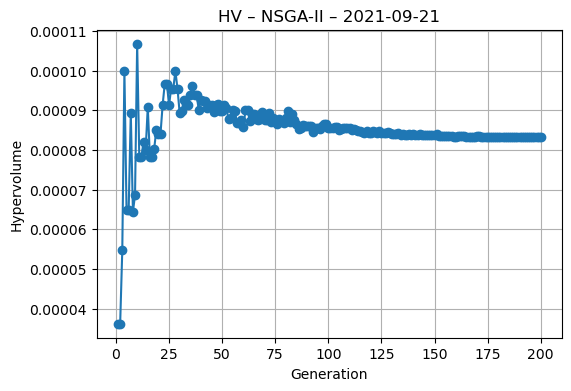

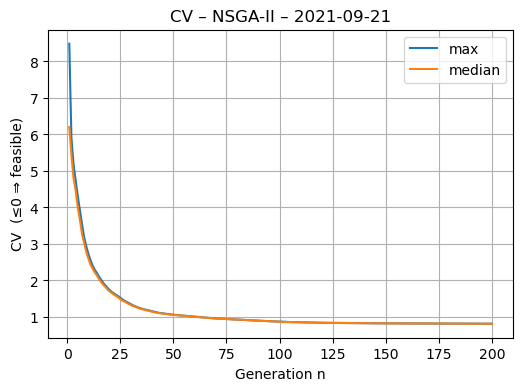

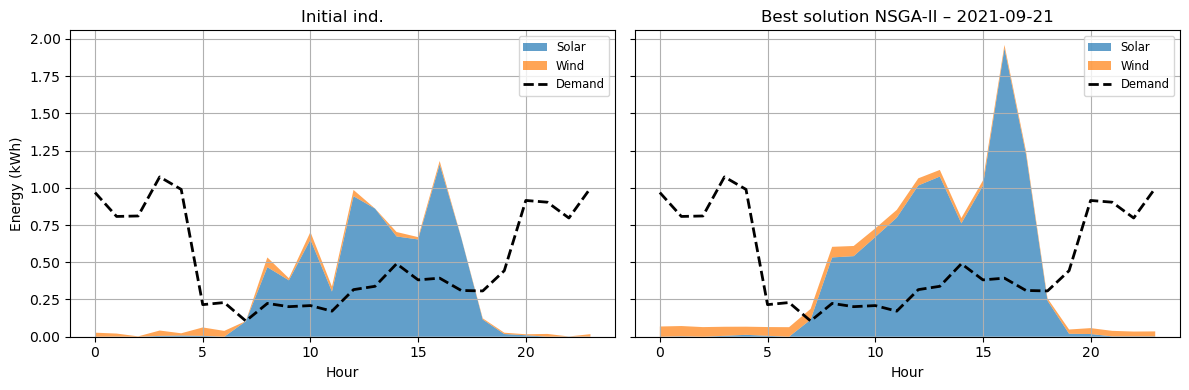

In [21]:
dia = dias_sel[4]   
alg = "NSGA-II"

res   = traer_res(resultados, dia, alg)           
z_ref = ref_point(resultados[str(dia)]["result"]) 

graficar_hv(res, z_ref, titulo=f"HV – {alg} – {dia}")
graficar_cv(res, titulo=f"CV – {alg} – {dia}")

# Demanda real del día en cuestión.
D_t, *_ = preparar_dia(df_copy, dia)

# Primer individuo de la población en la generación 0.
ind_init = res.history[0].pop.get("X")[0]

F_front = F(res)  
X_front = X_seguro(res) 

# Mejor individuo en base a el menor coste del consumidor (para este caso).
best_idx = np.argmin(F_front[:, 2])
ind_best = X_front[best_idx]

ini_vs_final(ind_init, ind_best, D_t,
             lbl_a="Initial ind.",
             lbl_b=f"Best solution {alg} – {dia}")

En la memoria se analiza porque tenemos unfeasibles y otros que son feasibles desde el inicio (constraint físico + curva de demanda).